<a href="https://colab.research.google.com/github/Hrimax/EnviARpaint/blob/main/image%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget 'https://raw.githubusercontent.com/Hrimax/EnviARpaint/main/datas2.txt?token=ATDIVHWWSIFLTAOS2CJG65LB2XNIM'

--2022-01-05 17:54:45--  https://raw.githubusercontent.com/Hrimax/EnviARpaint/main/datas2.txt?token=ATDIVHWWSIFLTAOS2CJG65LB2XNIM
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75 [text/plain]
Saving to: ‘datas2.txt?token=ATDIVHWWSIFLTAOS2CJG65LB2XNIM’

datas2.txt?token=AT 100%[===================>]      75  --.-KB/s    in 0s      

2022-01-05 17:54:45 (4.90 MB/s) - ‘datas2.txt?token=ATDIVHWWSIFLTAOS2CJG65LB2XNIM’ saved [75/75]



In [ ]:
f = open("datas2.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [ ]:
!mkdir data

In [ ]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sea%20turtle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/butterfly.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cell%20phone.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eraser.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flying%20saucer.npy


In [ ]:
%tensorflow_version 1.x

In [ ]:
import os
import glob
import numpy as np

from tensorflow.python.keras import layers
from tensorflow import keras 
import tensorflow as tf
print(tf.__version__)

print(len(os.listdir('data')))

1.15.2
9


In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

28800


sea_turtle


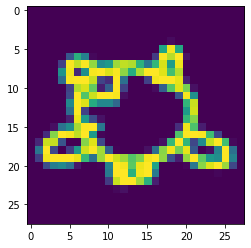

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
import cv2
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten(input_shape=x_train.shape[1:]))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax')) 

# Train model
adam = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 25920 samples, validate on 2880 samples
Epoch 1/5
25920/25920 - 17s - loss: 1.3586 - top_k_categorical_accuracy: 0.9047 - val_loss: 0.9238 - val_top_k_categorical_accuracy: 0.9566
Epoch 2/5
25920/25920 - 17s - loss: 0.7992 - top_k_categorical_accuracy: 0.9655 - val_loss: 0.7659 - val_top_k_categorical_accuracy: 0.9667
Epoch 3/5
25920/25920 - 17s - loss: 0.6590 - top_k_categorical_accuracy: 0.9730 - val_loss: 0.6540 - val_top_k_categorical_accuracy: 0.9729
Epoch 4/5
25920/25920 - 17s - loss: 0.5887 - top_k_categorical_accuracy: 0.9763 - val_loss: 0.6103 - val_top_k_categorical_accuracy: 0.9733
Epoch 5/5
25920/25920 - 17s - loss: 0.5332 - top_k_categorical_accuracy: 0.9785 - val_loss: 0.5635 - val_top_k_categorical_accuracy: 0.9771


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 98.00%


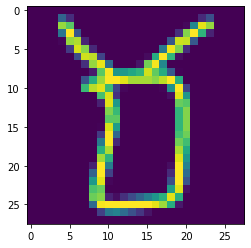

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 

In [ ]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]

latex = [class_names[x] for x in ind]
print(latex[0])
z=np.sum(pred)
pred1=(pred/z)*100
print(pred1[ind[0]])

drums
95.67589


In [ ]:
with open('datas2.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [ ]:
model.save('kerasf2.h5')
!mkdir zeta

In [ ]:
!cp ds1.txt model/class_namesds1.txt

cp: cannot stat 'ds1.txt': No such file or directory


In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_namesds1.txt (deflated 15%)


In [ ]:
from google.colab import files
files.download('datas2.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>